In [1]:
import os
import sys
import numpy as np
import cv2
import torch
import h5py

from pathlib import Path
from termcolor import colored, cprint
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import importlib 
import shutil
import time


from hloc import (extract_features, 
                  match_features,
                  localize_inloc, 
                  visualization, 
                  pairs_from_retrieval,
                  h5_IO)

In [2]:
print("GPU ON: ", torch.cuda.is_available())
images = Path("/home/shu/My/top_images")
images_train = images / "train"
images_test = images / "test"

outputs = Path("outputs/horn_top_cam/")
try:
    shutil.rmtree(outputs)
except:
    pass
finally:
    os.mkdir(outputs)

sfm_pairs_train = outputs / "pairs-netvlad-train.txt"
sfm_pairs_test = outputs / "pairs-netvlad-test.txt"

retrieval_conf = extract_features.confs["netvlad"]

GPU ON:  True


In [4]:
importlib.reload(h5_IO)

# load the vertices
bag_name = "20240404_032834"
vertices = h5_IO.vertices_from_csv(bag_name)
print("Vertices: ", vertices.shape)
print("Headers: ", vertices.columns)


# load the images by vertices
v_ts_df = vertices[[" timestamp [ns]"]]
images_dir = Path("/home/shu/My/ros_output")
images_files = os.listdir(images_dir)
images_files = [int(f[:-4]) for f in images_files]
images_files.sort()
images_files = np.array(images_files)

# find the closest images
v_img_ts_df = h5_IO.find_closest_img(v_ts_df, images_files)


# create the train directory
train_dir = Path("/home/shu/My/train")
if train_dir.exists():
    shutil.rmtree(train_dir)
os.mkdir(train_dir)
for i in range(v_img_ts_df.shape[0]):
    path = images_dir / str(v_img_ts_df.iloc[i, 1])
    try:
        shutil.copy(path, train_dir / str(v_img_ts_df.iloc[i, 1]))
    except:
        print("Error: ", path)
        pass


Vertices:  (180, 18)
Headers:  Index(['vertex index', ' timestamp [ns]', ' position x [m]', ' position y [m]',
       ' position z [m]', ' quaternion x', ' quaternion y', ' quaternion z',
       ' quaternion w', ' velocity x [m/s]', ' velocity y [m/s]',
       ' velocity z [m/s]', ' acc bias x [m/s^2]', ' acc bias y [m/s^2]',
       ' acc bias z [m/s^2]', ' gyro bias x [rad/s]', ' gyro bias y [rad/s]',
       ' gyro bias z [rad/s]'],
      dtype='object')


/home/shu/My/HLOC_dev/hloc/h5_IO.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'img_name'] = df.apply(lambda x: pool[np.argmin(np.abs(pool - x.iloc[0]))], axis=1)


In [8]:
# vertex images pairs
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

v_img_ts_df

,timestamp [ns],img_name
0,1712201316625133986,1712201316628046138.png
1,1712201318757738058,1712201318756633256.png
2,1712201320891074314,1712201320891825305.png
3,1712201321957730706,1712201321952079183.png
4,1712201322624399794,1712201322622881670.png
5,1712201323024391730,1712201323018924038.png
6,1712201323424393890,1712201323419414505.png
7,1712201323957729666,1712201323950495502.png
8,1712201324424393634,1712201324417498264.png
9,1712201324824391762,1712201324814859986.png


In [5]:
importlib.reload(extract_features)

start = time.time()
# build the database
retrieval_path_train = extract_features.main(retrieval_conf, train_dir, "train", outputs)
print("Retrieval path: ", retrieval_path_train)
cprint("Time: " + str(time.time() - start), "yellow")

[2024/05/01 15:02:39 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/05/01 15:02:39 hloc INFO] Found 180 images in root /home/shu/My/train.
[2024/05/01 15:02:39 hloc INFO] New to h5: 180 images.
100%|██████████| 180/180 [00:25<00:00,  7.17it/s]
[2024/05/01 15:03:09 hloc INFO] Finished exporting features.


Retrieval path:  outputs/horn_top_cam/global-feats-netvlad-train.h5
Time: 30.691377639770508


In [6]:
f = h5py.File(retrieval_path_train, 'r')
# h5_IO.recursive_list(f)
f.close()

In [7]:
importlib.reload(pairs_from_retrieval)

# create pairs for training DB 
start = time.time()
pairs_from_retrieval.main(retrieval_path_train, sfm_pairs_train, num_matched=3)
torch.cuda.empty_cache()

cprint("Time: " + str(time.time() - start), "yellow")

[2024/05/01 15:04:01 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/01 15:04:02 hloc INFO] Matching 180 query images to 180 database images.
[2024/05/01 15:04:02 hloc INFO] Matching torch.Size([180, 4096]) query images to torch.Size([180, 4096]) database images.
[2024/05/01 15:04:02 hloc INFO] Found 540 pairs.


score:  torch.Size([180, 180])
query:1712201421417520616.png, db:1712201422414963514.png, 0.9207288026809692
query:1712201421417520616.png, db:1712201419284178793.png, 0.7099564075469971
query:1712201421417520616.png, db:1712201320891825305.png, 0.667978823184967
query:1712201334085252319.png, db:1712201334618462434.png, 0.47419270873069763
query:1712201334085252319.png, db:1712201333483586466.png, 0.3825591504573822
query:1712201334085252319.png, db:1712201332951223813.png, 0.33182597160339355
query:1712201405021597510.png, db:1712201405549769099.png, 0.5216836929321289
query:1712201405021597510.png, db:1712201404482281655.png, 0.43158969283103943
query:1712201405021597510.png, db:1712201403948748807.png, 0.34511798620224
query:1712201340022639923.png, db:1712201339750667766.png, 0.49506625533103943
query:1712201340022639923.png, db:1712201339484081126.png, 0.3886430859565735
query:1712201340022639923.png, db:1712201340416480627.png, 0.3700133264064789
query:1712201368282820911.png, d

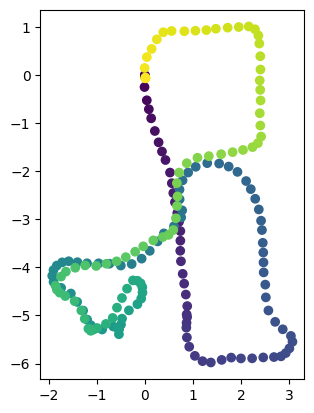

In [8]:
# vis vertice 
positions = vertices[[' position x [m]',
                     ' position y [m]',
                     ' position z [m]']].to_numpy()

# Create quaternions
quaternions = vertices[[' quaternion x',
                       ' quaternion y',
                       ' quaternion z',
                       ' quaternion w']].to_numpy()

# print(positions.shape, quaternions.shape)

# Normalize quaternions
quaternions /= np.linalg.norm(quaternions, axis=1)[:, None]

# Convert quaternions to angles
angles = 2 * np.arctan2(np.linalg.norm(quaternions[:, 0:3], axis=1), quaternions[:, 3])

# Compute arrow directions
u = np.cos(angles)
v = np.sin(angles)

fig, ax = plt.subplots()
colors = np.arange(len(positions))
# quiver plot with a scale of 1 for correct arrow direction
# ax.quiver(positions[:, 0], positions[:, 1], u, v, angles='xy', scale_units='xy', scale=1, width=0.005)

ax.scatter(positions[:, 0], positions[:, 1], c=colors, cmap='viridis')
ax.set_aspect('equal', adjustable='box')
plt.show()

In [9]:
importlib.reload(extract_features)

test_dir = Path("/home/shu/My/test")
if test_dir.exists():
    shutil.rmtree(test_dir)
os.mkdir(test_dir)

images_files = os.listdir(images_dir)
total_num = len(images_files)
pick = np.random.choice(total_num, 1, replace=False)
image_file = images_files[pick[0]]
print("Picked: ", image_file)
path = images_dir / image_file
shutil.copy(path, test_dir / image_file)

# remove the test h5 if it exists
test_h5 = outputs / "{}-test.h5".format(retrieval_conf["output"])
if os.path.isfile(test_h5):
    os.remove(test_h5)

# create the test h5
retrieval_path_test = extract_features.main(retrieval_conf, test_dir, "test", outputs)
print("Retrieval path: ", retrieval_path_test)

[2024/05/01 15:04:12 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2024/05/01 15:04:12 hloc INFO] Found 1 images in root /home/shu/My/test.
[2024/05/01 15:04:12 hloc INFO] New to h5: 1 images.


Picked:  1712201388616361803.png


100%|██████████| 1/1 [00:00<00:00,  4.08it/s]
[2024/05/01 15:04:17 hloc INFO] Finished exporting features.


Retrieval path:  outputs/horn_top_cam/global-feats-netvlad-test.h5


In [10]:
f = h5py.File(retrieval_path_test, 'r')
h5_IO.recursive_list(f)
f.close()

1712201388616361803.png Group
  global_descriptor Dataset
  image_size Dataset


In [11]:
importlib.reload(pairs_from_retrieval)
# query test and train db saperately
start = time.time()
res = False
_score = 0.8
while not res:
    _score -= 0.1
    cprint("Score: " + str(_score), "green")
    res = pairs_from_retrieval.main(retrieval_path_test, sfm_pairs_test, num_matched=3, 
                                    db_descriptors=retrieval_path_train,
                                    query_score=_score)
    if _score < 0.3:
        cprint("No pairs found", "red")
        break

torch.cuda.empty_cache()
print("Pairs found: ", res)
cprint("Time: " + str(time.time() - start), "yellow")

[2024/05/01 15:04:26 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/01 15:04:26 hloc INFO] Matching 1 query images to 180 database images.
[2024/05/01 15:04:26 hloc INFO] Matching torch.Size([1, 4096]) query images to torch.Size([180, 4096]) database images.
[2024/05/01 15:04:26 hloc INFO] Found 0 pairs.
[2024/05/01 15:04:26 hloc INFO] In query mode
[2024/05/01 15:04:26 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/01 15:04:26 hloc INFO] Matching 1 query images to 180 database images.


Score: 0.7000000000000001
score:  torch.Size([1, 180])
Score: 0.6000000000000001


[2024/05/01 15:04:26 hloc INFO] Matching torch.Size([1, 4096]) query images to torch.Size([180, 4096]) database images.
[2024/05/01 15:04:26 hloc INFO] Found 0 pairs.
[2024/05/01 15:04:26 hloc INFO] In query mode
[2024/05/01 15:04:26 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/01 15:04:26 hloc INFO] Matching 1 query images to 180 database images.
[2024/05/01 15:04:26 hloc INFO] Matching torch.Size([1, 4096]) query images to torch.Size([180, 4096]) database images.
[2024/05/01 15:04:26 hloc INFO] Found 2 pairs.
[2024/05/01 15:04:26 hloc INFO] In query mode


score:  torch.Size([1, 180])
Score: 0.5000000000000001
score:  torch.Size([1, 180])
query:1712201388616361803.png, db:1712201388883683867.png, 0.5741246938705444
query:1712201388616361803.png, db:1712201388486290880.png, 0.5262141227722168
Pairs found:  ('1712201388616361803.png', '1712201388883683867.png', 0.5741246938705444)
Time: 0.3796958923339844


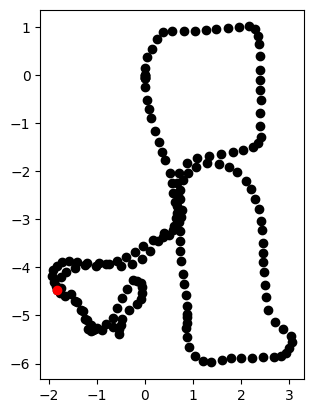

In [12]:
# vis query results
positions = vertices[[' position x [m]',
                     ' position y [m]',
                     ' position z [m]']].to_numpy()

if res:
    f_img = res[1]
    f_name = f_img.split(".")[0]
    
    f_row = v_img_ts_df[v_img_ts_df['img_name'] == f'{f_name}.png']
    v_ts = f_row.iloc[0, 0]
    v_raw = vertices[vertices[' timestamp [ns]'] == v_ts]
    pos_np = v_raw.iloc[:, 2:5].to_numpy()


fig, ax = plt.subplots()
colors = np.arange(len(positions))

ax.scatter(positions[:, 0], positions[:, 1], c="black")
ax.scatter(pos_np[:, 0], pos_np[:, 1], c="red")
ax.set_aspect('equal', adjustable='box')
plt.show()


In [125]:
importlib.reload(h5_IO)
# add train into the test
h5_IO.merge_hdf5(retrieval_path_train, retrieval_path_test)


In [126]:
importlib.reload(pairs_from_retrieval)
# query test and train db merged
start = time.time()
pairs_from_retrieval.main(retrieval_path_test, sfm_pairs_test, num_matched=3, 
                               db_descriptors=retrieval_path_test,
                               query_score=0.5)
torch.cuda.empty_cache()
cprint("Time: " + str(time.time() - start), "yellow")

[2024/05/01 12:02:54 hloc INFO] Extracting image pairs from a retrieval database.
[2024/05/01 12:02:54 hloc INFO] Matching 181 query images to 181 database images.
[2024/05/01 12:02:54 hloc INFO] Matching torch.Size([181, 4096]) query images to torch.Size([181, 4096]) database images.
[2024/05/01 12:02:54 hloc INFO] Found 180 pairs.


DB:  ['1712201339684992597.png', '1712201396151126146.png', '1712201364948244913.png', '1712201412753227803.png', '1712201399084886511.png', '1712201332951223813.png', '1712201403417949262.png', '1712201335816348014.png', '1712201388883683867.png', '1712201323950495502.png', '1712201323419414505.png', '1712201402416713462.png', '1712201389283846064.png', '1712201351284063740.png', '1712201347354967513.png', '1712201339750667766.png', '1712201339084956767.png', '1712201392291146808.png', '1712201385217583531.png', '1712201342417674412.png', '1712201359350451760.png', '1712201413824031424.png', '1712201416885754011.png', '1712201376684590463.png', '1712201330816150329.png', '1712201359753194199.png', '1712201355225390072.png', '1712201398684547603.png', '1712201341883219283.png', '1712201347753931065.png', '1712201318756633256.png', '1712201351682203160.png', '1712201344358025304.png', '1712201325228910088.png', '1712201356814990886.png', '1712201371883719795.png', '1712201387831846070.p

# Above already can find the coarse pair

### below is going to find precise location & pose

In [5]:
# dense matching by superpoint
feature_conf = extract_features.confs["superpoint_inloc"]
matcher_conf = match_features.confs["superglue"]
# matcher_conf = match_features.confs["superpoint+lightglue"]

%time feature_path = extract_features.main(feature_conf, images, outputs)
cprint("Features extracted! ", "red")

match_path = match_features.main(
    matcher_conf, sfm_pairs, feature_conf["output"], outputs
)

[2024/03/08 19:51:13 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}
[2024/03/08 19:51:14 hloc INFO] Found 1340 images in root datasets/loc.


Loaded SuperPoint model


100%|██████████████████████████████████████████████████████████████████████████████████████████| 1340/1340 [01:48<00:00, 12.30it/s]
[2024/03/08 19:53:02 hloc INFO] Finished exporting features.
[2024/03/08 19:53:02 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


CPU times: user 1min 50s, sys: 1.97 s, total: 1min 51s
Wall time: 1min 48s
Features extracted! 
Loaded SuperGlue model ("outdoor" weights)


  0%|                                                                                                     | 0/3705 [00:00<?, ?it/s]


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/shu/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/shu/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shu/miniconda3/envs/pytorch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/shu/My/HLOC_dev/hloc/match_features.py", line 127, in __getitem__
    grp = fd[name0]
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/home/shu/miniconda3/envs/pytorch/lib/python3.10/site-packages/h5py/_hl/group.py", line 357, in __getitem__
    oid = h5o.open(self.id, self._e(name), lapl=self._lapl)
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "h5py/h5o.pyx", line 189, in h5py.h5o.open
KeyError: "Unable to synchronously open object (object '0704.png' doesn't exist)"
